In [ ]:
import pandas as pd
import duckdb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

# Funções Auxiliares

In [ ]:
def conferir_missing(df):
    missing_found = False
    for col in df.columns:
        # Conta NaNs
        n_null = df[col].isnull().sum()
        # Conta 'unknown' apenas em colunas do tipo object (strings)
        n_unknown = 0
        if df[col].dtype == 'object':
            n_unknown = (df[col] == 'unknown').sum()

        total_missing = n_null + n_unknown

        if total_missing > 0:
            missing_found = True
            perc = round(100 * total_missing / len(df), 2)
            print(f"{col}: {total_missing} missing ({perc}%)")

    if not missing_found:
        print('Não há missing no banco de dados')


def categorize_corr(val):
    if abs(val) >= 0.7:
        return 'Alto'
    elif abs(val) >= 0.4:
        return 'Moderado'
    elif abs(val) >= 0.1:
        return 'Baixo'
    else:
        return 'Nenhum'


# Ingestão e Armazenamento

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data_Engineer_JR_TOTVS/bank.xls', delimiter=',')

In [ ]:
con = duckdb.connect('bank.duckdb')
con.register('bank', df)

In [ ]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [ ]:
df.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
balance,int64
housing,object
loan,object
contact,object
day,int64


# Exploração de Dados

### Quantas linhas e colunas o dataset possui?


In [ ]:
print(len(df))
print(len(df.columns))

11162
17


In [ ]:
n_linhas = con.execute("SELECT COUNT(*) FROM bank").fetchone()[0]
n_colunas = con.execute("""
    SELECT COUNT(*)
    FROM information_schema.columns
    WHERE table_name = 'bank'
""").fetchone()[0]


print(f"O dataset possui {n_linhas} linhas e {n_colunas} colunas.")

O dataset possui 11162 linhas e 17 colunas.


### Existem valores nulos? Em quais colunas e quantos?

In [ ]:
conferir_missing(df)

job: 70 missing (0.63%)
education: 497 missing (4.45%)
contact: 2346 missing (21.02%)
poutcome: 8326 missing (74.59%)


In [ ]:
cols = df.select_dtypes(include='object').columns.to_list()
query = "SELECT\n"
query += ",\n".join([f"COUNT(*) FILTER (WHERE \"{col}\" = 'unknown') AS unknown_{col}" for col in cols])
query += "\nFROM bank;"
result = con.execute(query).fetchdf()
print(result.T)


                      0
unknown_job          70
unknown_marital       0
unknown_education   497
unknown_default       0
unknown_housing       0
unknown_loan          0
unknown_contact    2346
unknown_month         0
unknown_poutcome   8326
unknown_deposit       0


### Qual a correlação entre variáveis numéricas??

In [ ]:
numerical_cols = df.select_dtypes(include='number').columns.to_list()
print("Colunas numéricas:", numerical_cols)

Colunas numéricas: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']


In [ ]:
corr_matrix = pd.DataFrame(np.eye(len(numerical_cols)), columns=numerical_cols, index=numerical_cols)

results = []

for i in range(len(numerical_cols)):
    for j in range(i+1, len(numerical_cols)):
        col1 = numerical_cols[i]
        col2 = numerical_cols[j]

        query = f"SELECT CORR({col1}, {col2}) FROM bank"
        corr_value = con.execute(query).fetchone()[0]

        results.append((col1, col2, corr_value))

for col1, col2, corr in results:
    corr_matrix.loc[col1, col2] = corr
    corr_matrix.loc[col2, col1] = corr

print(corr_matrix)

           age  balance   day  duration  campaign  pdays  previous
age       1.00     0.11 -0.00      0.00     -0.01   0.00      0.02
balance   0.11     1.00  0.01      0.02     -0.01   0.02      0.03
day      -0.00     0.01  1.00     -0.02      0.14  -0.08     -0.06
duration  0.00     0.02 -0.02      1.00     -0.04  -0.03     -0.03
campaign -0.01    -0.01  0.14     -0.04      1.00  -0.10     -0.05
pdays     0.00     0.02 -0.08     -0.03     -0.10   1.00      0.51
previous  0.02     0.03 -0.06     -0.03     -0.05   0.51      1.00


/tmp/ipython-input-122-1319401606.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_labels = corr_matrix.applymap(categorize_corr)


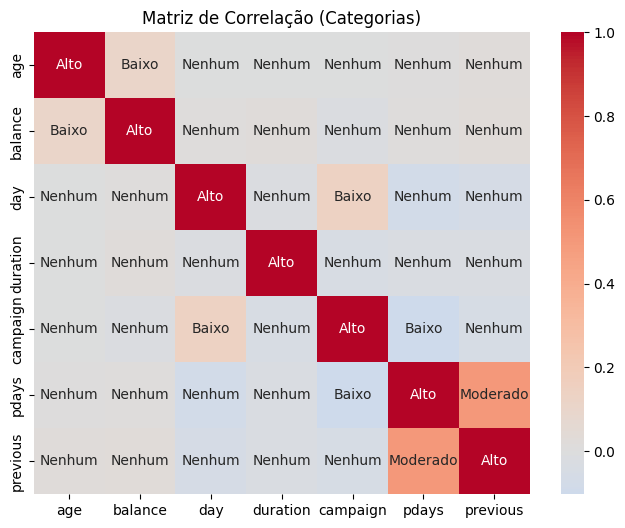

In [ ]:
annot_labels = corr_matrix.applymap(categorize_corr)


plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=annot_labels, fmt='', cmap='coolwarm', center=0)
plt.title('Matriz de Correlação (Categorias)')
plt.show()

# Pré-processamento


### Trate valores nulos adequadamente.

In [ ]:
df['job'] = df['job'].replace('unknown', df['job'].mode()[0]) # porque a a proporção é baixa: 0.63% mas, também posso apagar
df['education'] = df['education'].replace('unknown', df['education'].mode()[0]) # porque a a proporção é baixa: 4.45%
df['poutcome'] = df['poutcome'].replace('unknown', 'sem_contato_anterior') # como a proporção é alta, 74% vale a pena manter esses valores

### Converta variáveis categóricas para numéricas (One-Hot Encoding ou Ordinal).

In [ ]:
for col in ['default', 'housing', 'loan', 'deposit']:
    print(f"Valores únicos em {col}: {df[col].unique()}")


Valores únicos em default: ['no' 'yes']
Valores únicos em housing: ['yes' 'no']
Valores únicos em loan: ['no' 'yes']
Valores únicos em deposit: ['yes' 'no']


In [ ]:
binarias = ['deposit', 'default', 'housing', 'loan']

for col in binarias:
    df[col] = df[col].map({'yes': 1, 'no': 0})

In [ ]:
df["deposit"]

,deposit
0,1
1,1
2,1
3,1
4,1
...,...
11157,0
11158,0
11159,0
11160,0


In [ ]:
categ_nomes = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
df_encoded = pd.get_dummies(df, columns=categ_nomes, drop_first=True)

In [ ]:
df_encoded.head()

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_sem_contato_anterior,poutcome_success
0,59,0,2343,1,0,5,1042,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
1,56,0,45,0,0,5,1467,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
2,41,0,1270,1,0,5,1389,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
3,55,0,2476,1,0,5,579,1,-1,0,...,False,False,False,True,False,False,False,False,True,False
4,54,0,184,0,0,5,673,2,-1,0,...,False,False,False,True,False,False,False,False,True,False


In [ ]:
conferir_missing(df_encoded)

Não há missing no banco de dados


### Divisão do treino e teste

In [ ]:
X = df_encoded.drop('deposit', axis=1)
y = df_encoded['deposit']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

### Normalize ou padronize colunas numéricas, se necessário.

In [ ]:
num_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Modelagem

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### Resultados da base de treino

In [ ]:
y_pred = model.predict(X_train)

recall = recall_score(y_train, y_pred)
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
confusion_mat = confusion_matrix(y_train, y_pred)

In [ ]:
print(f'Recall: {recall*100:.2f}%')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'F1-Score: {f1*100:.2f}%')

Recall: 79.47%
Accuracy: 82.45%
Precision: 82.80%
F1-Score: 81.10%


### Resultados da base de teste

In [ ]:
y_pred = model.predict(X_test)

recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
confusion_mat = confusion_matrix(y_test, y_pred)

In [ ]:
print(f'Recall: {recall*100:.2f}%')
print(f'Accuracy: {accuracy*100:.2f}%')
print(f'Precision: {precision*100:.2f}%')
print(f'F1-Score: {f1*100:.2f}%')

Recall: 79.58%
Accuracy: 82.59%
Precision: 82.98%
F1-Score: 81.25%


In [ ]:
joblib.dump(model, 'model_bank.pkl')

['model_bank.pkl']

In [ ]:
joblib.dump(scaler, 'scaler_bank.pkl')

['scaler_bank.pkl']